In [2]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [3]:
import random

import torch
import pickle
import torch.utils.data
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from data.IGs import IGsDatasetDGL


Using backend: pytorch


In [4]:
def track_list_to_adjacency_matrix(track_list):
    # Determine the maximum number of nodes in the track
    num_nodes = max(track_list) + 1

    # Create an empty adjacency matrix
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Add connections to the adjacency matrix
    for i in range(len(track_list) - 1):
        current_node = track_list[i]
        next_node = track_list[i + 1]
        adjacency_matrix[current_node][next_node] = 1

    return adjacency_matrix


data_list = []
dataset = []

with open(prj_path + 'ig_subgraphs.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

for data in data_list:
    obj = {
        'num_node': len(data[0]),
        'node_type': torch.tensor(data[0], dtype=torch.int8),
        'adj' : torch.tensor(track_list_to_adjacency_matrix(data[0]), dtype=torch.int8),
        'target': torch.tensor(data[1])
    }
    dataset.append(obj)

with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [5]:
train, test_val_data = train_test_split(dataset, test_size=0.3, random_state=42)
test, val = train_test_split(test_val_data, test_size=0.7, random_state=42)

start = time.time()
with open(prj_path + 'igraph-GTN-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-test.pkl','wb') as f:
        pickle.dump(test, f)
with open(prj_path + 'igraph-GTN-val.pkl','wb') as f:
        pickle.dump(val, f)

print('Time (sec):',time.time() - start)

Time (sec): 8.505125999450684


In [6]:
datasetDGL = IGsDatasetDGL()

[I] Loading data ...
preparing 50599 graphs for the TRAIN set...


c:\Users\andri\Progetti\igraph_transformer\data\IGs.py:166: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  edge_list = (adj != 0).nonzero()  # converting adj matrix to edge_list


preparing 15181 graphs for the VAL set...
preparing 6505 graphs for the TEST set...
[I] Finished loading.
Time taken: 350.7980s


In [7]:
# Save IG dataset DGL
start = time.time()
with open(prj_path + 'igraph-DGL.pkl', 'wb') as f:
        pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
print('Time (sec):',time.time() - start)

Time (sec): 37.359867811203


In [8]:
print(len(datasetDGL.train))
print(len(datasetDGL.val))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.val[0])
print(datasetDGL.test[0])

50599
15181
6505
(Graph(num_nodes=13, num_edges=4,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor(6))
(Graph(num_nodes=10, num_edges=4,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor(6))
(Graph(num_nodes=4, num_edges=3,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor(4))


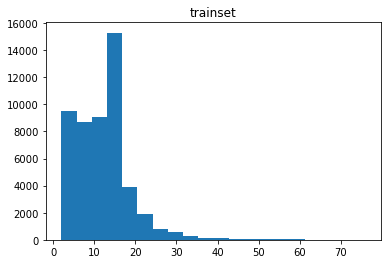

min/max : 2 76


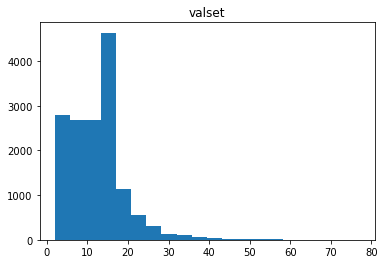

min/max : 2 77


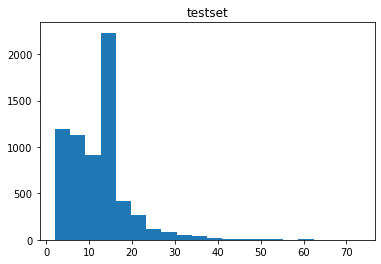

min/max : 2 73


In [9]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')